## Train/Evaluate a DNN for AMC

This notebook demonstrates how to create a neural network and a trainer in PyTorch to learn a signal classification task.  The reference dataset used is the RML2016.10A dataset for Automatic Modulation Classification

### Assumptions
- The dataset wrangling has already been completed (and is provided here)
- The classifier evaluation code (and the plotting) has already been completed

### Components Recreated in Tutorial
- Deep Neural Network Model defined in PyTorch
- Training Loop that trains for *n* epochs

### See Also
The code in this tutorial is a stripped down version of the code in ``rfml.nn.model.CNN`` and ``rfml.nn.train.StandardTrainingStrategy`` that simplifies discussion.  Further detail can be provided by directly browsing the source files for those classes.

## Install the library code and dependencies

In [1]:
# Install the library code
#!pip install git+https://github.com/brysef/rfml.git@1.0

In [2]:
# IPython Includes (just for documentation)
from IPython.display import Image

# Ensure that the least loaded GPU is used
import setGPU

# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
from rfml.data import Dataset, Encoder
from rfml.data.converters import load_RML201610A_dataset

from rfml.nbutils import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections, compute_confusion
from rfml.nn.model import Model

setGPU: Setting GPU to: 1


## Configuration

In [3]:
gpu = True       # Set to True to use a GPU for training
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = None # Set to a file path if you've downloaded RML2016.10A locally

### Loading a Dataset

The dataset used is downloaded from DeepSig Inc. and provided under a Creative Commons lic

In [4]:
dataset = load_RML201610A_dataset(path=data_path)
print(len(dataset))
pprint(dataset.get_examples_per_class())

220000
{'8PSK': 20000,
 'AM-DSB': 20000,
 'AM-SSB': 20000,
 'BPSK': 20000,
 'CPFSK': 20000,
 'GFSK': 20000,
 'PAM4': 20000,
 'QAM16': 20000,
 'QAM64': 20000,
 'QPSK': 20000,
 'WBFM': 20000}


In [5]:
train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
train, val = train.split(frac=0.05, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 13280,
 'AM-DSB': 13280,
 'AM-SSB': 13280,
 'BPSK': 13280,
 'CPFSK': 13280,
 'GFSK': 13280,
 'PAM4': 13280,
 'QAM16': 13280,
 'QAM64': 13280,
 'QPSK': 13280,
 'WBFM': 13280}

Validation Examples
{'8PSK': 700,
 'AM-DSB': 700,
 'AM-SSB': 700,
 'BPSK': 700,
 'CPFSK': 700,
 'GFSK': 700,
 'PAM4': 700,
 'QAM16': 700,
 'QAM64': 700,
 'QPSK': 700,
 'WBFM': 700}

Testing Examples
{'8PSK': 6020,
 'AM-DSB': 6020,
 'AM-SSB': 6020,
 'BPSK': 6020,
 'CPFSK': 6020,
 'GFSK': 6020,
 'PAM4': 6020,
 'QAM16': 6020,
 'QAM64': 6020,
 'QPSK': 6020,
 'WBFM': 6020}


In [6]:
le = Encoder(["WBFM",
              "AM-DSB",
              "AM-SSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print(le)

WBFM: 0
AM-DSB: 1
AM-SSB: 2
CPFSK: 3
GFSK: 4
BPSK: 5
QPSK: 6
8PSK: 7
PAM4: 8
QAM16: 9
QAM64: 10



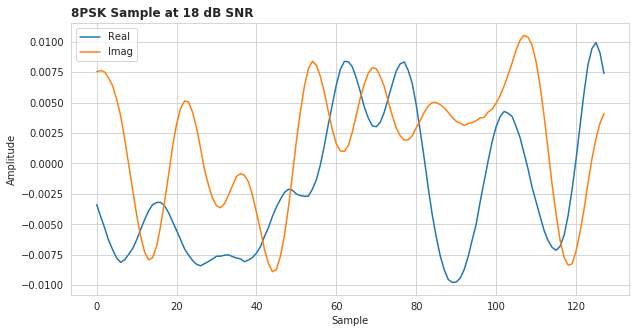

In [7]:
# Plot a sample of the data
# You can choose a different sample by changing
idx = 10
snr = 18.0
modulation = "8PSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Creating a Neural Network Model
We are going to recreate a Convolutional Neural Network (CNN) based on the "VT_CNN2" Architecture.  This network is based off of a network for modulation classification first
introduced in [O'Shea et al.] and later updated by [West/Oshea] and [Hauser et al.]
to have larger filter sizes.

#### Citations
##### O'Shea et al.
T. J. O'Shea, J. Corgan, and T. C. Clancy, “Convolutional radio modulation recognition networks,” in International Conference on Engineering Applications of Neural Networks, pp. 213–226, Springer,2016.

##### West/O'Shea
N. E. West and T. O’Shea, “Deep architectures for modulation recognition,” in IEEE International Symposium on Dynamic Spectrum Access Networks (DySPAN), pp. 1–6, IEEE, 2017.

##### Hauser et al.
S. C. Hauser, W. C. Headley, and A. J.  Michaels, “Signal detection effects on deep neural networks utilizing raw iq for modulation classification,” in Military Communications Conference, pp. 121–127, IEEE, 2017.

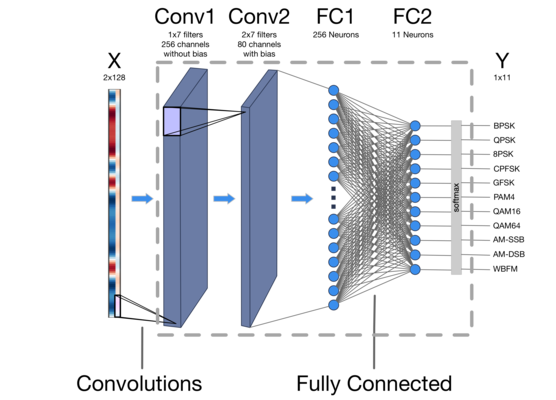

In [8]:
Image(filename="_fig/CNNDiagramSmall.png")

In [9]:
class MyCNN(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        # Modifying the first convolutional layer to not use a bias term is a
        # modification made by Bryse Flowers due to the observation of vanishing
        # gradients during training when ported to PyTorch (other authors used
        # Keras).
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        # Batch x Features
        self.dense1 = nn.Linear(80 * 1 * input_samples, 256)
        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a3(x)
        x = self.n3(x)

        x = self.dense2(x)

        return x

In [10]:
model = MyCNN(input_samples=128, n_classes=11)
print(model)

MyCNN(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=10240, out_features=256, bias=True)
  (a3): ReLU()
  (n3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=11, bias=True)
)
----------------------
Trainable Parameters: 2914299
Fixed Parameters: 0
Total Parameters: 2914299
----------------------



### Implementing a Training Loop

In [11]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 3, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            train_loss = self._train_one_epoch(
                model=model, data=train_data, loss_fn=criterion, optimizer=optimizer
            )
            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

In [12]:
trainer = MyTrainingStrategy(gpu=gpu)
print(trainer)

MyTrainingStrategy(lr=0.001, n_epochs=3, gpu=True)


### Putting it All Together

In [13]:
train_loss, val_loss = trainer(model=model,
                               training=train,
                               validation=val,
                               le=le)

On Epoch 0 the training loss was 1.4342133136062356
---- validation loss was 1.2560550197958946
On Epoch 1 the training loss was 1.2019110159440474
---- validation loss was 1.1962882988154888
On Epoch 2 the training loss was 1.1413198417716928
---- validation loss was 1.172751747071743


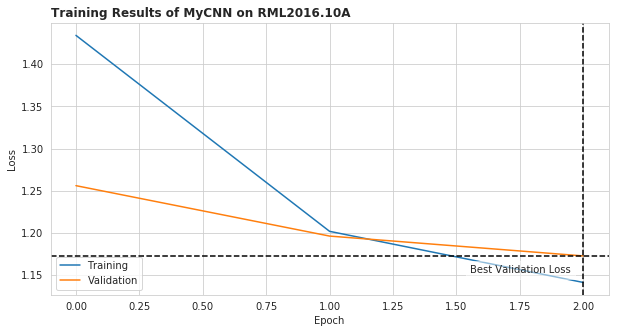

In [14]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_convergence(train_loss=train_loss, val_loss=val_loss, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Testing the Trained Model

In [15]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.5430


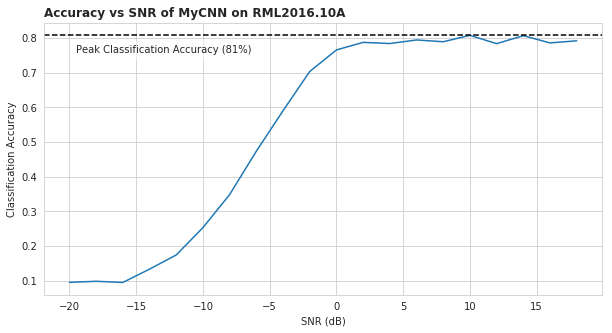

In [16]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

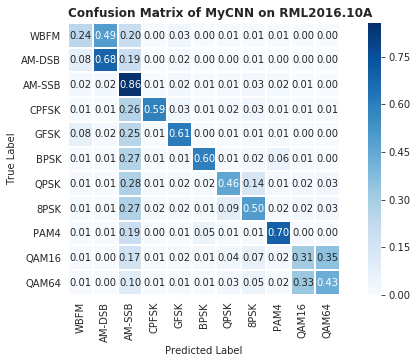

In [17]:
cmn = compute_confusion(model=model, data=test, le=le)

title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="MyCNN", dataset_name="RML2016.10A")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()